In [180]:
from fbprophet import Prophet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def SMAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_pred-y_true) / (y_pred+y_true))) * 2

In [140]:
# # FB Prophet
# targets = ['PM2.5', 'PM10', 'O3']
# for target in targets:
#     df[target] = np.log(df[target])
    
# tmp = df[['utc_time', 'PM2.5']]
# tmp.columns = ['ds', 'y']

# m = Prophet(changepoint_prior_scale=0.01).fit(tmp)
# future = m.make_future_dataframe(periods=300, freq='H')
# fcst = m.predict(future)
# m.plot(fcst);

In [141]:
df_aq = pd.read_csv("../input/beijing_1701_1803.csv")
df_meo = pd.read_csv("../input/beijing_17_18_meo.csv")
df_aq.utc_time = pd.to_datetime(df_aq.utc_time) + pd.Timedelta('08:00:00')
df_meo.utc_time = pd.to_datetime(df_meo.utc_time) + pd.Timedelta('08:00:00')

In [142]:
df_aq = df_aq[df_aq.stationId == "daxing_aq"]
df_meo = df_meo[df_meo.station_id == "daxing_meo"]
df_meo.rename(columns={'station_id':'stationId'}, inplace=True)

In [143]:
df_aq.stationId = df_aq.stationId.apply(lambda s: s[:-3])
df_meo.stationId = df_meo.stationId.apply(lambda s: s[:-4])

In [144]:
df = pd.merge(df_aq, df_meo, how='inner', on=['stationId', 'utc_time'])

df['year'] = df.utc_time.dt.year
df['month'] = df.utc_time.dt.month
df['day'] = df.utc_time.dt.day
df['hour'] = df.utc_time.dt.hour
df['weekday'] = df.utc_time.dt.weekday
df.fillna(method='ffill', inplace=True)
df = pd.get_dummies(df, columns=['weather'])

df_train = df[df.utc_time < '2018-01-31 00:00:00']
df_test = df[df.utc_time >= '2018-01-31 00:00:00']

X_cols = ['temperature', 'pressure', 'humidity','wind_direction', 'wind_speed', 'year', 'month', 'day', 'hour', 'weekday', 
          'weather_Dust', 'weather_Fog', 'weather_Haze', 'weather_Rain', 'weather_Sand', 'weather_Sleet', 'weather_Snow', 'weather_Sunny/clear']
X = df_train[X_cols]
# X.year = X.year.astype('category')
# X.month = X.month.astype('category')
# X.day = X.day.astype('category')
# X.hour = X.hour.astype('category')
# X.weekday = X.weekday.astype('category')

In [218]:
df.head()

,stationId,utc_time,PM2.5,PM10,NO2,CO,O3,SO2,longitude,latitude,...,weekday,weather_Dust,weather_Fog,weather_Haze,weather_Rain,weather_Sand,weather_Sleet,weather_Snow,weather_Sunny/clear,y_pred
0,daxing,2017-01-31 00:00:00,25.0,63.0,14.0,0.4,78.0,8.0,116.354444,39.718611,...,1,0,0,1,0,0,0,0,0,25.0
1,daxing,2017-01-31 01:00:00,101.0,124.0,30.0,0.7,89.0,21.0,116.354444,39.718611,...,1,0,0,1,0,0,0,0,0,101.0
2,daxing,2017-01-31 02:00:00,64.0,78.0,27.0,0.6,71.0,13.0,116.354444,39.718611,...,1,0,0,1,0,0,0,0,0,64.0
3,daxing,2017-01-31 03:00:00,58.0,86.0,22.0,0.7,74.0,16.0,116.354444,39.718611,...,1,0,0,1,0,0,0,0,0,58.0
4,daxing,2017-01-31 04:00:00,71.0,90.0,22.0,0.7,70.0,28.0,116.354444,39.718611,...,1,0,0,1,0,0,0,0,0,71.0


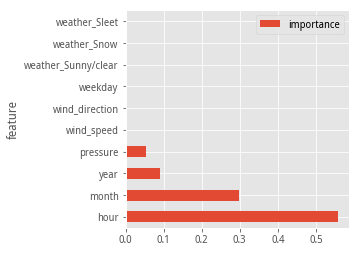

In [217]:
importance = sorted(zip(map(lambda x: round(x, 4), dt.feature_importances_), X.columns), reverse=True)[:10]
df_importance = pd.DataFrame(importance)
df_importance.columns = ['importance', 'feature']
df_importance.set_index('feature').plot(kind='barh', figsize=(4, 4))